In [255]:
import CVIs
import helper
import methods 


In [256]:
import inspect

functs = [f for _, f in inspect.getmembers(methods, inspect.isfunction)]

print(functs)

for fn in functs:
    vars = fn.__code__.co_varnames
    print(vars)


[<function CAL at 0x12cc43040>, <function K_means at 0x12bb541f0>, <function PCKM at 0x12cc3e3a0>, <function average_linkage at 0x12bb77310>, <function euclidean_distances at 0x12a2c3820>, <function fcluster at 0x12bb52670>, <function linkage at 0x12bb72550>]
('data', 'K', 'ML', 'CL')
('data', 'K')
('data', 'K', 'ML', 'CL')
('data', 'K', 'dis_mat', 'X', 'Z')
('X', 'Y', 'Y_norm_squared', 'squared', 'X_norm_squared', 'original_shape')
('Z', 't', 'criterion', 'depth', 'R', 'monocrit', 'n', 'T')
('y', 'method', 'metric', 'optimal_ordering', 'n', 'method_code', 'result')


In [257]:
import numpy as np
np.ones((2,3,4))

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [258]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt

def computeClusterSim1(cdata:dict, conn:np.array, cluster_number:int) -> np.array:
    sim = np.zeros((cluster_number, cluster_number))
    for i in np.arange(cluster_number-1):
        for j in np.arange(i+1, cluster_number):
            t = conn[cdata[i],:][:,cdata[j]] # all edges in the two clusters
            nnn = np.sum(t.flatten() > 0)
            if nnn:
                sim[i,j] = (np.sum(t.flatten())**3)/nnn**2
                sim[j,i] = sim[i,j]
    return sim

def computeMySWC(A,cl,cores,pdist,local_core):
    ncores = len(cores)
    D = A[cores,:] # extract all cores
    cl_cores = cl[cores]
    ncl = list(Counter(local_core).values()) # counts the elements' frequency# the number of points belining to each core
    ncl[ncl == 0] = 0 ## Is this really needed here? 

    # silhouette of the cores and their cluster labels
    np.fill_diagonal(pdist, 0)
    
    _,s = silhouette_index_terms(D,cl_cores,pdist)

    mcv = 0
    for i in np.arange(ncores):
        
        mcv = mcv + s[i]*ncl[i]
    
    return mcv/A.shape[0]


def silhouette_index_terms(data,cluster_labels,d):
    uc = np.unique(cluster_labels)
    K = len(uc)

    if K == 1: # A single label
        cvi = 0
        cvi_terms = np.zeros(len(cluster_labels))
        return cvi, cvi_terms
    
    cvia = np.zeros(len(cluster_labels)) # array to store a's
    cvib = np.zeros(len(cluster_labels)) # array to store b's

    for i in np.arange(K):
        this_cluster = cluster_labels == uc[i]
        nk = np.sum(this_cluster)

        if nk > 1: # guard against one-element clusters
            #print('d[this_cluster, this_cluster] = ', d[this_cluster,:][:,this_cluster])
            cvia[this_cluster] = (np.mean(d[this_cluster,:][:,this_cluster], axis=1) * nk) / (nk-1)

            bb = np.array([])
            for j in np.arange(K):
                if i != j:
                    other_cluster = cluster_labels == uc[j]
                    if bb.shape[0] > 0:
                        bb = np.vstack((bb, np.mean(d[this_cluster,:][:,other_cluster], axis=1)))
                    else:
                        bb = np.mean(d[this_cluster,:][:,other_cluster], axis=1)
                        
            cvib[this_cluster] = np.min(bb, axis=0)
        else:
            ## She does not like one-element clusters to contribute to the silhouette index. We can take care of this right here
            # But why, on earth, does she wat to dicount clusters with one CORE
            cvia[this_cluster] = 1
            cvib[this_cluster] = 1
    
    vec = cvib - cvia
    max_vals = np.max(np.vstack((cvia,cvib)), axis=0)


    cvi_terms = [vec[i]/ max_vals[i] for i in np.arange(len(vec))]
    cvi = np.mean(cvi_terms)
    return cvi, cvi_terms


In [259]:
import os

def LCCV(data) -> np.array:
    
    N,n = data.shape
    dist = euclidean_distances(data,data)
    s_dist = np.sort(dist, axis=1)
    index = np.argsort(dist, axis=1)


    ### NaN-searching algorithm ###
    r = 1
    nb = np.zeros(N, dtype='int')
    count1 = 0
    flag = False
    RNN = np.zeros((N,N))
    while not flag:
        for i in np.arange(N):
            k = index[i, r+1]
            nb[k] += 1
            RNN[k,int(nb[k])] = i
        r += 1
        count2 = np.sum(nb == 0)
        if count2 == 0 or count1 == count2:
            flag = True
        else:
            count1 = count2

    lambda_r = r - 1
    max_nb = np.max(nb)


    # desnity of each point
    ### There is a discrepancy with the original paper! The author
    ### says that ONLY the distances of the reverse neighbours are
    ### added in the denominator. However, in their implementation,
    ### the MAX_NB are added, not just the reverse neighbours'!
    rho = np.zeros(N)
    Non = int(max_nb)
    for i in np.arange(N):
        d = np.sum(s_dist[i, 0:Non+1])
        
        rho[i] = Non/d

    ### LORE algorithm ###
    # sort the points according to the density
    # rho_sorted = np.sort(rho)[::-1]

    #print(len(np.unique(rho)))
    ord_rho = np.argsort(rho)[::-1]

    local_core = np.zeros(N, dtype='int')
    for i in np.arange(N):
        p = ord_rho[i]
        neighbourhood = index[p, 0:nb[p]+1]

        qq = np.argmax(rho[neighbourhood])
        max_index = neighbourhood[qq]

        if local_core[max_index] == 0:
            local_core[max_index] = max_index

        
        for j in np.arange(nb[p]+1):
            j = int(j)
            if local_core[neighbourhood[j]] == 0:
                local_core[neighbourhood[j]] = local_core[max_index]
            else: # RCR rule
                q = int(local_core[neighbourhood[j]])
            
                if dist[neighbourhood[j], q] > dist[neighbourhood[j], int(local_core[max_index])]:
                    local_core[neighbourhood[j]] = local_core[max_index]
            # Determine the representative according to RTR
            for m in np.arange(N):
                if local_core[m] == neighbourhood[j]:
                    local_core[m] = local_core[neighbourhood[j]]

    # find the cores
    cores = np.unique(local_core)
    cluster_number = len(cores)
    cl = local_core.copy()

    # Graph based distances (Connectivity)
    conn = np.zeros((N,N))
    weight = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(1, lambda_r+1):
            x = index[i,j]
            conn[i,x] = 1/(1+dist[i,x])
            conn[x,i] = conn[i,x]
            weight[i,x] = dist[i,x]

    # comput the shortest path between cores
    shortest_path = np.zeros((cluster_number,cluster_number))
    weight2 = nx.DiGraph(weight)

    for i in np.arange(cluster_number):
        shortest_path[i,i] = 0
        for j in np.arange(i+1,cluster_number):
            
            try:
                shortest_path[i,j] = nx.dijkstra_path_length(weight2, cores[i], cores[j])
            except nx.NetworkXNoPath:
                shortest_path[i,j] = 0

            shortest_path[j,i] = shortest_path[i,j]
    max_d = np.max(shortest_path)
    shortest_path[shortest_path == 0] = max_d

    results = {}

    # Compute the similarity between clusters
    cdata = {} # create a dictionary to stor the points in each cluster
    nc = np.zeros(cluster_number)
    for i in np.arange(cluster_number):
        this_cluster = (cl == cores[i])
        nc[i] = np.sum(this_cluster)
        cdata[i] = np.asarray(this_cluster).nonzero()[0]

    sim = computeClusterSim1(cdata,conn,cluster_number)

    results[0] = {'cdata':cdata, 'cl':cl}

    # Merge the small clusters ------
    small_threshold = N/cluster_number
    clunum2 = cluster_number
    for i in np.arange(cluster_number):
        if nc[i] <= small_threshold:
            # find the most similar cluster

            v, ic = np.max(sim[i,:]), np.argmax(sim[i,:])

            # If there are no clusters conncting the small clusters
            # the small clusters are considered as outliers
            # ----- label 0
            if v == 0 and nc[i] < small_threshold/2:
                cl[cdata[i]] = 0 # should this be -1 for python???
                cdata[i] = []
                nc[i] = 0
                clunum2 = clunum2 - 1
            
            if v > 0:
                clunum2 = clunum2 - 1
                # merge the clusters
                cdata[ic] = np.append(cdata[ic], cdata[i], axis=0)
                nc[ic] = nc[ic] + nc[i]
                nc[i] = 0
                cdata[i] = []

                # update sim
                sim = computeClusterSim1(cdata, conn, cluster_number)

    # obtain the clustering results after merging small clusters
    for i in np.arange(cluster_number):
        cl[cdata[i]] = i

    # pack the cluster numbers
    for i in np.arange(cluster_number):
        if nc[i] == 0:
            for j in np.arange(i+1,cluster_number):
                cl[cdata[j]] = cl[cdata[j]] - 1

    # data - data set
    # cl - cluster labels in the reduced nubmer of clusters (1, 2, ...)
    # clunum2 - reduced number of clusters
    # cores - the original number of cores
    # short_path - the shortest path between original cores
    # local_core - cl before they were reduced and relabelled ?

    mcv = computeMySWC(data,cl,cores.astype(int),shortest_path,local_core)

    results[cluster_number - clunum2] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum2}

    ## Now the algorithm itself
    clunum = clunum2

    while clunum > 2:

        # store the results
        results[cluster_number - clunum] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum}
        
        # find the two clusters with the largest similarity
        ls_row, index_rows = np.max(sim, axis=0), np.argmax(sim,axis=0)
        idy = np.argmax(ls_row)
        idx = index_rows[idy]

        results[cluster_number - clunum ]['merge'] = [idx,idy]

        # merge the clusters
        if idx != idy:
            pp = np.sort([idx,idy])
            idx, idy = pp[0], pp[1]
            cdata[idx] = np.append(cdata[idx], cdata[idy], axis=0)
            nc[idx] = len(cdata[idx])
            cdata[idy] = []
            nc[idy] = 0
            clunum = clunum - 1

            # update sim
            sim = computeClusterSim1(cdata,conn,cluster_number)

            # obtain the clustering results
            for i in np.arange(cluster_number): # renumber the clusters
                cl[cdata[i]] = i

            # pack the cluster numbers
            for i in np.arange(cluster_number):
                if nc[i] == 0:
                    for j in np.arange(i+1,cluster_number):
                        cl[cdata[j]] = cl[cdata[j]] - 1
            
            mcv = computeMySWC(data,cl,cores.astype(int),shortest_path,local_core)

            if clunum == 2:
                results[cluster_number - clunum] = {'cdata':cdata,'cl':cl.copy(),'sim':sim,'mcv':mcv,'clunum':clunum}
        else:
            results[cluster_number -  2] = {'cdata':[],'cl':[],'sim':[],'mcv':[]}
            break

    # obtain the best clustering results from a series of results

    cls = []
    cv = []

    for i in results.keys():
        if 'mcv' in results[i]:
            cv.append(results[i]['mcv'])
            cls.append(results[i]['cl'])

    bestcvi, id = np.max(cv), np.argmax(cv) # best value of the CVI
    bestcl = cls[id] # correspoinding labels

    return bestcl, bestcvi



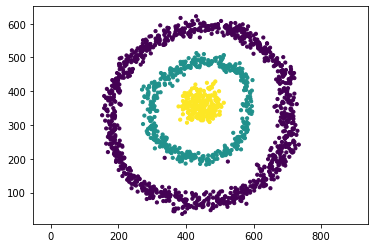

In [260]:
data = pd.read_csv('../datasets/circle.csv', header=None)
data = np.asarray(data)

bestcl, bestcvi = LCCV(data)

plt.figure()
plt.axis('equal')
plt.scatter(data[:,0], data[:,1], 10, bestcl)